In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import minimize  # 优化函数
import statsmodels.api as sm
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [24]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

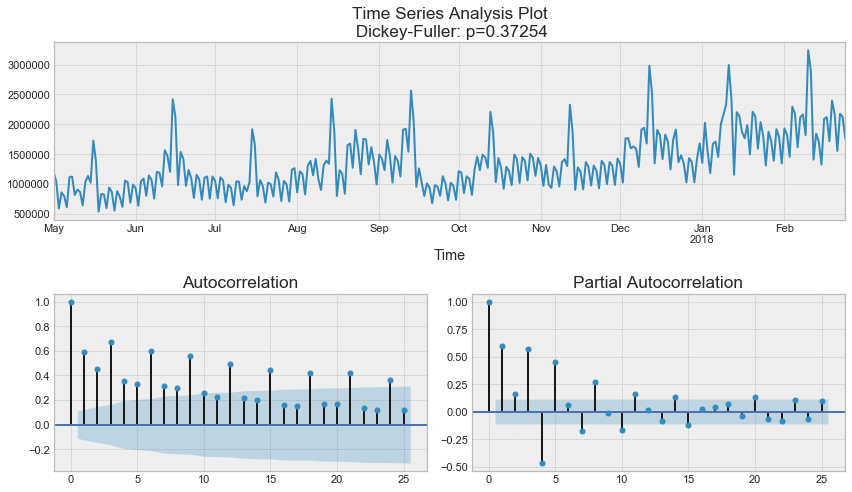

In [25]:
currency = pd.read_csv('currency.csv',  index_col='Time', parse_dates=['Time'])

# plot ACF, PACF

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    '''
    plot time series, its ACF, PACF, calculate Dickey-Fuller test
    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    '''
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plot\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(currency.GEMS_GEMS_SPENT)

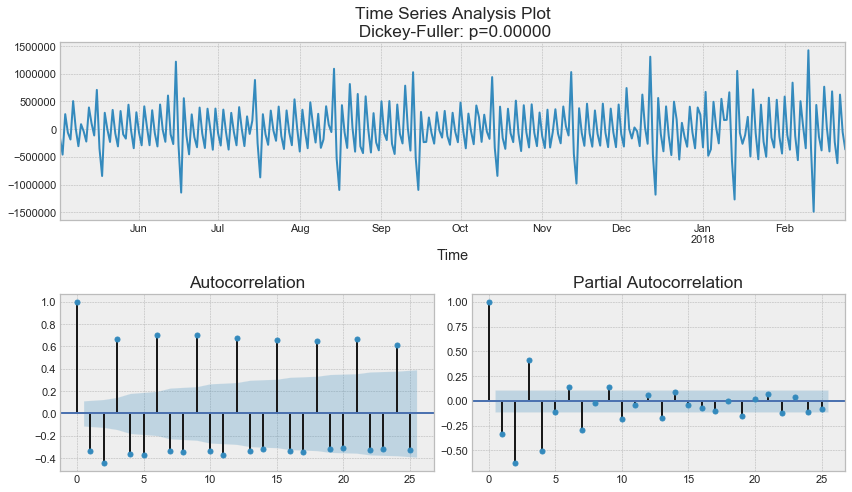

In [26]:
currency_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(1)
tsplot(currency_diff[1:])

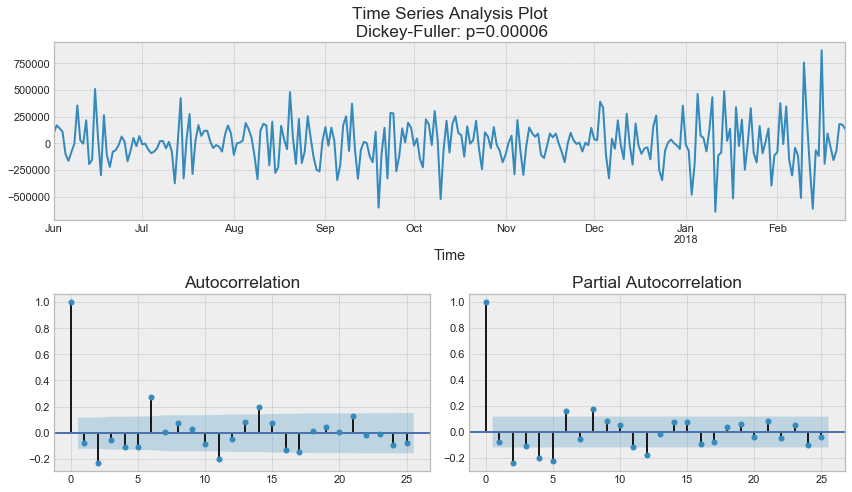

In [27]:
currency_diff = currency_diff - currency_diff.shift(30) # seasonal
tsplot(currency_diff[30+1:])

In [28]:
# setting initial values for parameters
p = range(2, 6)
d = 1
q = range(2, 7)
P = range(0, 2)
Q = range(0, 3)
s = 30
D = 1
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

120

In [29]:
# find the best parameters for SARIMA model

def optimizeSARIMA(parameters_list, d, D, s):
    '''
    return dataframe with parameters and corresponding AIC
    '''
    
    results = []
    best_aic = float("inf")
    
    for param in tqdm_notebook(parameters_list):
        # we need to try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        
        aic = model.aic
        
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [16]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [30]:
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, p),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(5, 1, 5)x(0, 1, [1], 30)   Log Likelihood               -3602.439
Date:                              Fri, 05 Mar 2021   AIC                           7228.877
Time:                                      17:31:09   BIC                           7272.014
Sample:                                  05-01-2017   HQIC                          7246.201
                                       - 02-24-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6734      0.187     -3.592      0.000      -1.041      -0.306
ar.L2         -0.50

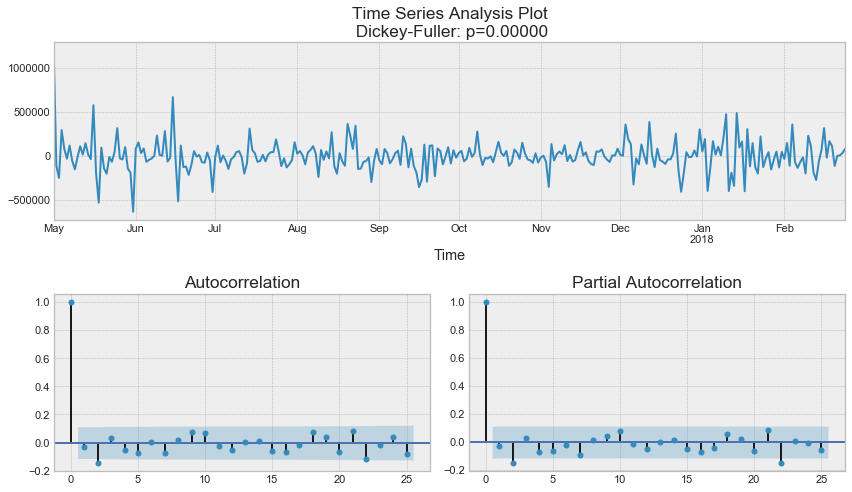

In [31]:
tsplot(best_model.resid)

In [32]:
def plotSARIMA(series, model, n_steps):
    '''
    plot model vs predicted values
    '''
    
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    
    # making a shift on s+d steps, because these values were unobsered by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title('Mean Absolute Percentage Error: {0:.02f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label='actual')
    plt.legend()
    plt.grid(True)

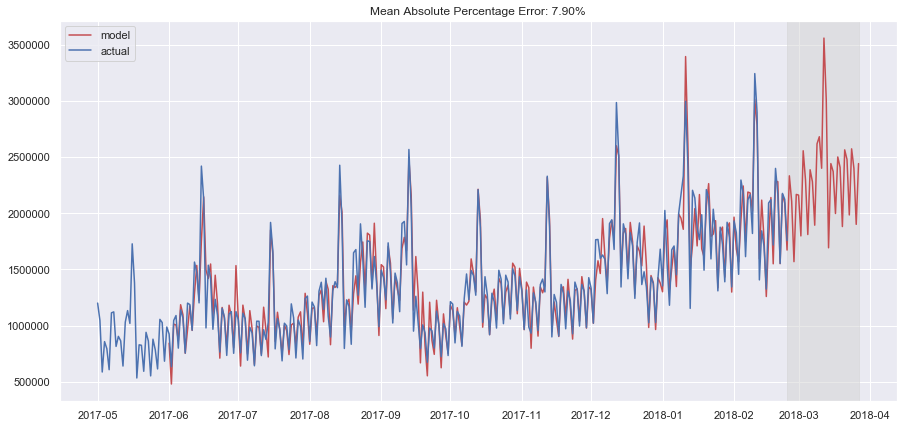

In [33]:
plotSARIMA(currency, best_model, 30)